## NPS and Wait Time Pulled from 2024

In [ ]:
import pandas as pd

# Load your CSV file
df = pd.read_csv('AWT vs. NPS v3.csv')

# Convert 'CREATED_AT' to datetime, handling mixed formats
df['CREATED_AT'] = pd.to_datetime(df['CREATED_AT'], format='mixed', errors='coerce')

# Drop rows with invalid dates (optional, based on your needs)
df = df.dropna(subset=['CREATED_AT'])

# Create a new column for the hour of the appointment
df['hour'] = df['CREATED_AT'].dt.floor('H')

# Extract the date for the "Date" column
df['Date'] = df['hour'].dt.date

# Classify NPS scores into Promoters, Passives, and Detractors
df['promoter'] = df['NET_PROMOTER_SCORE'].apply(lambda x: 1 if 9 <= x <= 10 else 0)
df['detractor'] = df['NET_PROMOTER_SCORE'].apply(lambda x: 1 if 0 <= x <= 6 else 0)

# Group by hour and calculate required columns
hourly_nps = df.groupby('hour').agg(
    Date=('Date', 'first'),  # Extract the date for the period
    WAIT=('WAIT_TIME', 'mean'),  # Average wait time
    promoters_count=('promoter', 'sum'),
    detractors_count=('detractor', 'sum'),
    total_count=('NET_PROMOTER_SCORE', 'count')
)

# Calculate %Promoters and %Detractors
hourly_nps['%promoters'] = hourly_nps['promoters_count'] / hourly_nps['total_count'] * 100
hourly_nps['%detractors'] = hourly_nps['detractors_count'] / hourly_nps['total_count'] * 100

# Calculate NPS
hourly_nps['NPS'] = hourly_nps['%promoters'] - hourly_nps['%detractors']

# Select and rename columns
hourly_nps = hourly_nps[['Date', 'WAIT', 'NPS']]

# Save the result to a new CSV file
hourly_nps.to_csv('Hourly_NPS_with_WAIT.csv', index=False)

print(hourly_nps)


                           Date       WAIT        NPS
hour                                                 
2024-11-26 00:00:00  2024-11-26  84.802703  87.770270
2024-11-26 01:00:00  2024-11-26  77.094702  87.019868
2024-11-26 02:00:00  2024-11-26  94.356798  85.438233
2024-11-26 03:00:00  2024-11-26  79.499346  89.856021
2024-11-26 04:00:00  2024-11-26  85.056116  87.578815
2024-11-26 05:00:00  2024-11-26  81.707105  86.863271
2024-11-26 06:00:00  2024-11-26  77.283702  86.250838
2024-11-26 07:00:00  2024-11-26  79.265190  87.594937
2024-11-26 08:00:00  2024-11-26  90.742414  86.850978
2024-11-26 09:00:00  2024-11-26  82.971237  88.227425
2024-11-26 10:00:00  2024-11-26  88.349120  87.415426
2024-11-26 11:00:00  2024-11-26  87.173543  86.574984
2024-11-26 12:00:00  2024-11-26  83.797836  84.719405
2024-11-26 13:00:00  2024-11-26  83.446213  84.213877
2024-11-26 14:00:00  2024-11-26  83.689044  87.840405
2024-11-26 15:00:00  2024-11-26  82.956815  89.001350
2024-11-26 16:00:00  2024-11

/tmp/ipykernel_7404/3028278122.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['CREATED_AT'].dt.floor('H')


<bound method NDFrame.describe of           Date      WAIT        NPS  Linear_Regression_NPS  \
0   2024-11-26  1.413378  87.770270              86.848945   
1   2024-11-26  1.284912  87.019868              87.725838   
2   2024-11-26  1.572613  85.438233              85.762032   
3   2024-11-26  1.324989  89.856021              87.452276   
4   2024-11-26  1.417602  87.578815              86.820116   
5   2024-11-26  1.361785  86.863271              87.201113   
6   2024-11-26  1.288062  86.250838              87.704337   
7   2024-11-26  1.321086  87.594937              87.478915   
8   2024-11-26  1.512374  86.850978              86.173219   
9   2024-11-26  1.382854  88.227425              87.057300   
10  2024-11-26  1.472485  87.415426              86.445490   
11  2024-11-26  1.452892  86.574984              86.579229   
12  2024-11-26  1.396631  84.719405              86.963263   
13  2024-11-26  1.390770  84.213877              87.003265   
14  2024-11-26  1.394817  87.840405 

In [12]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 48.4 MB/s eta 0:00:00:00:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


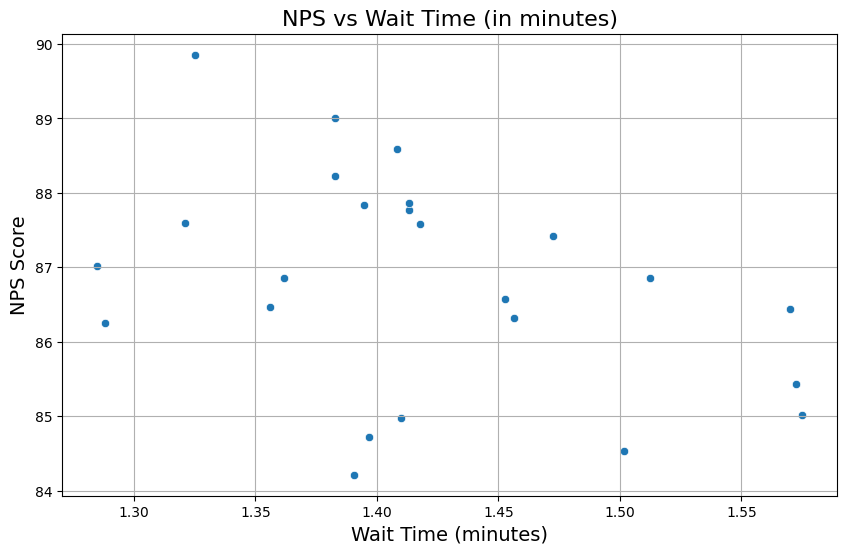

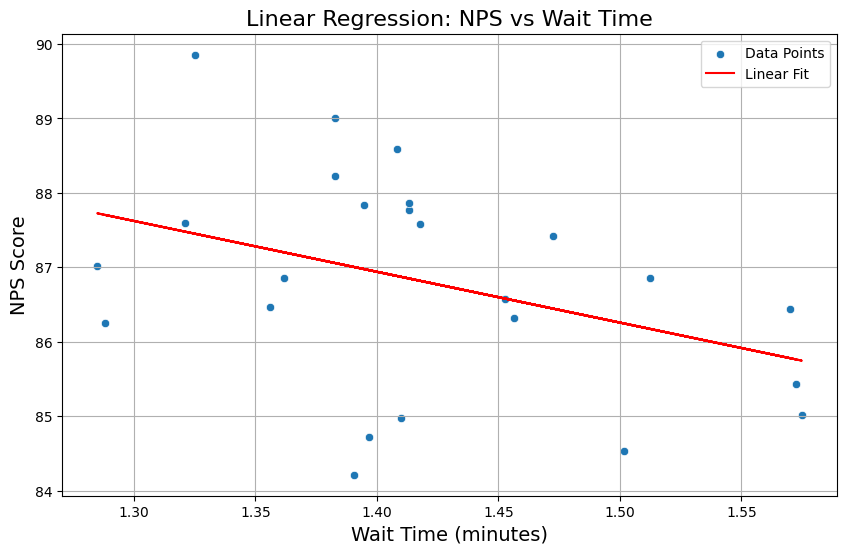

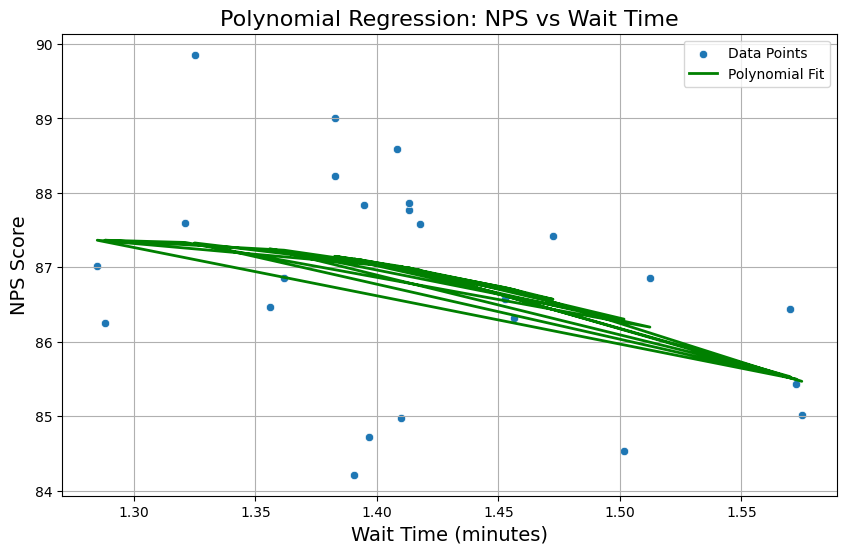

Estimated wait time when NPS drops below 80 using Linear Regression: 2.42 minutes
Estimated wait time when NPS drops below 80 using Polynomial Regression: 4674.32 minutes


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.regression.quantile_regression import QuantReg
import numpy as np

# Load the processed data
hourly_nps = pd.read_csv('Hourly_NPS_with_WAIT_in_Minutes.csv')

# Scatter plot of NPS vs WAIT (in minutes)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='WAIT', y='NPS', data=hourly_nps)
plt.title('NPS vs Wait Time (in minutes)', fontsize=16)
plt.xlabel('Wait Time (minutes)', fontsize=14)
plt.ylabel('NPS Score', fontsize=14)
plt.grid(True)
plt.show()

# Linear Regression to model the relationship between WAIT and NPS
X = hourly_nps[['WAIT']]  # Independent variable (Wait Time)
y = hourly_nps['NPS']  # Dependent variable (NPS)

# Fit linear regression model
linear_reg = LinearRegression()
linear_reg.fit(X, y)

# Predict NPS using linear regression
hourly_nps['Linear_Regression_NPS'] = linear_reg.predict(X)

# Plot the linear regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x='WAIT', y='NPS', data=hourly_nps, label='Data Points')
plt.plot(hourly_nps['WAIT'], hourly_nps['Linear_Regression_NPS'], color='red', label='Linear Fit')
plt.title('Linear Regression: NPS vs Wait Time', fontsize=16)
plt.xlabel('Wait Time (minutes)', fontsize=14)
plt.ylabel('NPS Score', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Polynomial Regression to better fit the relationship (if non-linear)
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(X)

# Fit polynomial regression model
poly_reg = LinearRegression()
poly_reg.fit(X_poly, y)

# Predict NPS using polynomial regression
hourly_nps['Polynomial_Regression_NPS'] = poly_reg.predict(X_poly)

# Plot the polynomial regression curve
plt.figure(figsize=(10, 6))
sns.scatterplot(x='WAIT', y='NPS', data=hourly_nps, label='Data Points')
plt.plot(hourly_nps['WAIT'], hourly_nps['Polynomial_Regression_NPS'], color='green', label='Polynomial Fit', linewidth=2)
plt.title('Polynomial Regression: NPS vs Wait Time', fontsize=16)
plt.xlabel('Wait Time (minutes)', fontsize=14)
plt.ylabel('NPS Score', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Quantile Regression to model the threshold (NPS dropping below 80)
quant_reg = QuantReg(y, X)
res = quant_reg.fit(q=0.25)  # 25th percentile (first quartile)
threshold_pred = res.predict(np.array([[80]]))

# Find when NPS drops below 80 using linear regression model
wait_time_for_80_linear = (80 - linear_reg.intercept_) / linear_reg.coef_[0]

# Find when NPS drops below 80 using polynomial regression model
wait_time_for_80_poly = poly_reg.intercept_ + poly_reg.coef_[1] * 80

# Output the results
print(f"Estimated wait time when NPS drops below 80 using Linear Regression: {wait_time_for_80_linear:.2f} minutes")
print(f"Estimated wait time when NPS drops below 80 using Polynomial Regression: {wait_time_for_80_poly:.2f} minutes")

# Save updated data with predictions for visualization
hourly_nps.to_csv('Hourly_NPS_with_Predictions.csv', index=False)
